# [NSF's OIR Lab](https://nationalastro.org/) Astro Data Archive: How to make an exposure map for a survey


Knut Olsen, [Community Science and Data Center](https://nationalastro.org/programs/csdc/)

### Table Of Contents:
* [Goals & notebook summary](#goals)
* [Imports and setup](#init)
* [Details](#details)
* [Where do we look for the fields that we need?](#hdu_search)
* [Doing the search](#search)
* [Combining results](#combine)
* [Computing $t_{\rm eff}$](#teff)
* [Making the depth map](#depth)
* [Resources and references](#doc)



<a class="anchor" id="goals"></a>
# Goals
Use the Advanced Search API to make an exposure map for a survey.  We'll use the Dark Energy Survey DES) as an example.

# Notebook Summary
We show you how to use the API to search the Archive for relevant information from individual r-band HDUs as well as the primary HDUs.  We'll combine information on FWHM, transparency, and sky background to compute maps of effective exposure time, following the procedure adopted by DES.

<a class="anchor" id="init"></a>

# Imports and setup

In [1]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

Using server on https://astroarchive.noirlab.edu
About NSF's OIR Lab Astro Data Archive: https://astroarchive.noirlab.edu/about/


In [2]:
import sys
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import requests
import json
import healpy as hp
from pprint import pprint as pp  # pretty print

print(f'Using Python version: {sys.version}\n')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]

This Jupyter Notebook uses (some of) these packages:

#pandas==0.23.4
pandas==1.1.4
#matplotlib==3.0.2
matplotlib==3.3.3
#ipython==7.2.0
jupyter==1.0.0
#requests==2.22.0
requests==2.25.0
#astropy==3.2.1
astropy==4.1
#pytest==5.3.5
pytest==6.1.2
healpy==1.14.0



In [3]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

adsurl = f'{natroot}/api/adv_search'
adsurl

Using server on https://astroarchive.noirlab.edu
About NSF's OIR Lab Astro Data Archive: https://astroarchive.noirlab.edu/about/


'https://astroarchive.noirlab.edu/api/adv_search'

## Details <a id="details"/>


The effective exposure time ratio is defined by Nielsen et al. (2016) in their equation 2:

$\tau$ = $\eta^2 ({\rm FWHM}/0.9")^{-2}(b/b_{\rm dark})^{-1}$

where $\eta$ is the atmospheric transparency, FWHM is the full width of the PSF, $b$ is the sky brightness, and $b_{\rm dark}$ is the fiducial dark sky background. The effective exposure time, which accounts for the factors that influence the depth of an exposure, is then:

$t_{\rm eff} = \tau \times t_{\rm exp}$

In order to make a depth map of a survey, we will use the Advanced Search API to get the terms of this equation for individual HDUs.  We will make a Healpix map that counts $t_{\rm eff}$ in the healpixels on the sky overlapping with those HDUs.  Our goal is to be able to adjust e.g. density maps of sources on the sky for differences in depth across a survey.


## Where do we look for the fields that we need? <a id="hdu_search" />  
Some of the fields that we need, in particular the locations of the HDU corners, the FWHM of the PSF, and the sky level, are written into individual HDU headers by the DECam Community Pipeline.  So, we'll look at the fields in the aux_hdu_fields service for decam instcal-processed frames:

In [4]:
f'{adsurl}/aux_hdu_fields/decam/instcal/'

'https://astroarchive.noirlab.edu/api/adv_search/aux_hdu_fields/decam/instcal/'

In [5]:
requests.get(f'{adsurl}/aux_hdu_fields/decam/instcal/').json()

[{'Field': 'ARAWGAIN', 'Type': 'str', 'Desc': '[e/adu] Average raw gain'},
 {'Field': 'AVSIG', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSKY', 'Type': 'str', 'Desc': ''},
 {'Field': 'BIASFIL', 'Type': 'str', 'Desc': 'Bias'},
 {'Field': 'BPM', 'Type': 'str', 'Desc': 'Bad pixel mask'},
 {'Field': 'BPMFIL', 'Type': 'str', 'Desc': 'BPM file used to build mask'},
 {'Field': 'CCDNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'CD1_1', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD1_2', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD2_1', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD2_2', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CENDEC1', 'Type': 'str', 'Desc': 'Mosaic CCD center'},
 {'Field': 'CENRA1', 'Type': 'str', 'Desc': 'Mosaic CCD center'},
 {'Field': 'COR1DEC1', 'Type': 'str', 'Desc': 'Mosaic CCD corner'},
 {'Field': 'COR1RA1', 'Type': 'str', 'Desc': 'Mosaic CCD corner'},
 {'Field': 'COR2DEC1', 'Type': 'str', 'Desc': 'Mosaic CCD corner'},
 {

Going through all of the fields requires some digging, but through experimentation we decide that we need these fields:

* COR[1-4]RA1
* COR[1-4]DEC1
* FWHM
* AVSKY

However, we're still missing information on transparency.  Keywords related to transparency (e.g. AIRMASS) are generally written into the primary HDU for the full file, so we'll look at the AUX fields available in the full file search service:

In [6]:
requests.get(f'{adsurl}/aux_file_fields/decam/instcal/').json()

[{'Field': 'AIRMASS', 'Type': 'str', 'Desc': 'airmass'},
 {'Field': 'AOS', 'Type': 'str', 'Desc': 'AOS data available if true'},
 {'Field': 'ASTIG1', 'Type': 'str', 'Desc': '4MAPS correction 1'},
 {'Field': 'ASTIG2', 'Type': 'str', 'Desc': '4MAPS correction 2'},
 {'Field': 'ATTNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSIG', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSKY', 'Type': 'str', 'Desc': ''},
 {'Field': 'AZ', 'Type': 'str', 'Desc': 'Telescope azimuth'},
 {'Field': 'BAND', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAM', 'Type': 'str', 'Desc': 'BCAM data available if true'},
 {'Field': 'BCAMAX',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about x-axis'},
 {'Field': 'BCAMAY',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about y-axis'},
 {'Field': 'BCAMAZ',
  'Type': 'str',
  'Desc': '[arcsec] BCAM hexapod rot. about z-axis'},
 {'Field': 'BCAMDX', 'Type': 'str', 'Desc': '[micron] BCAM hexapod x-offset'},
 {'Field': 'BCAMDY', 'Type': 'str', 'Desc': '[micron] 

Again with some digging and experimentation, we'd like to pull out:
* G-TRANSP (transparency as measured by the guider)
* AIRMASS (to check that transparency correlates with airmass, as it should on clear nights)

Since we're going to use information from two database tables, we'll also need a way to join them.  The unique file identifier MD5SUM (called "fitsfile" in the AUX HDU service) will let us do that.


## Doing the search <a id="search" />
So let's issue our searches to the services.  Following the examples in the Advanced Search notebook, we'll start by getting the transparency information from the full file service.  We constraint the search by specifying the instrument, proc_type, prod_type, obs_type, proposal, and filter:

In [7]:
%%time
jj = {
    "outfields" : [
        "md5sum",
        "AIRMASS",
        "G-TRANSP",
    ],
    "search" : [
        ["caldat", "2018-09-01", "2020-09-01"], #@@@
        ["proposal", "2012B-0001"], #@@@
        ["instrument", "decam"],
        ["proc_type", "instcal"],
        ["prod_type", "image"],
        ["obs_type", "object"],
        ["ifilter", "r DECam", "contains"]
    ]
}
dff = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=500000'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    dff = pd.DataFrame(response.json()[1:])
    print(f'File records retrieved: {dff.shape}')
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use

File records retrieved: (4406, 3)
CPU times: user 53.3 ms, sys: 12.4 ms, total: 65.8 ms
Wall time: 9.49 s


In [8]:
dff.head()

,md5sum,AIRMASS,G-TRANSP
0,000a19954c5db4ee288d37ff1897ba05,1.07,0.551
1,00139ba7a4203845149f6799da1d1696,1.24,0.662
2,00166c324a32e15bb4043fc9bf20c0f0,1.00,0.647
3,0017b2aacef4b4f24b4ecab12da3bc15,1.27,0.587
4,0038cef6eb8d75e7c5900a6106af9fde,1.18,0.556


Now we'll get the information needed from the individual HDUs.  This will take longer, because the number of HDUs is nearly two orders of magnitude larger than the number of full files.

In [9]:
%%time
jj = {
    "outfields" : [
        "fitsfile",
        "hdu_idx",
        "fitsfile__archive_filename",
        "fitsfile__exposure",
        "fitsfile__ifilter",
        "CENRA1",
        "CENDEC1",
        "COR1RA1",
        "COR2RA1",
        "COR3RA1",
        "COR4RA1",
        "COR1DEC1",
        "COR2DEC1",
        "COR3DEC1",
        "COR4DEC1",
        "FWHM",
        "AVSKY",
    ],
    "search" : [
        ["fitsfile__caldat", "2018-09-01", "2020-09-01"], #@@@
        ["fitsfile__proposal", "2012B-0001"], #@@@
        ["fitsfile__instrument", "decam"],
        ["fitsfile__proc_type", "instcal"],
        ["fitsfile__prod_type", "image"],
        ["fitsfile__obs_type", "object"],
        ["fitsfile__ifilter", "r DECam", "contains"]
    ]
}
df2 = None # Pandas DataFrame
apiurl=f'{adsurl}/hasearch/?limit=5000000'
#apiurl=f'{adsurl}/hasearch/?limit=None' #@@@
response = requests.post(apiurl,json=jj, timeout=(3.05, 36000))

if response.status_code == 200:
    df2 = pd.DataFrame(response.json()[1:])
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use

CPU times: user 4.93 s, sys: 2.77 s, total: 7.7 s
Wall time: 1min 33s


In [10]:
print(f'HDU records retrieved: {df2.shape}')
df2.head()

HDU records retrieved: (268766, 17)


,fitsfile,hdu_idx,fitsfile__archive_filename,fitsfile__exposure,fitsfile__ifilter,CENRA1,CENDEC1,COR1RA1,COR2RA1,COR3RA1,COR4RA1,COR1DEC1,COR2DEC1,COR3DEC1,COR4DEC1,FWHM,AVSKY
0,000a19954c5db4ee288d37ff1897ba05,0,/net/archive/pipe/20181210/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,41.68790,-48.71611,41.46260,41.46034,41.91491,41.91410,-48.64060,-48.78969,-48.64222,-48.79117,6.013596,201.5105
1,000a19954c5db4ee288d37ff1897ba05,1,/net/archive/pipe/20181210/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,42.15821,-48.71718,41.93222,41.93105,42.38467,42.38511,-48.64233,-48.79127,-48.64281,-48.79175,5.940202,201.6173
2,000a19954c5db4ee288d37ff1897ba05,2,/net/archive/pipe/20181210/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,42.62910,-48.71594,42.40218,42.40304,42.85448,42.85680,-48.64209,-48.79103,-48.64042,-48.78950,5.916426,201.5151
3,000a19954c5db4ee288d37ff1897ba05,3,/net/archive/pipe/20181210/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,41.45015,-48.87902,41.22467,41.22154,41.67832,41.67660,-48.80312,-48.95223,-48.80550,-48.95456,5.947411,202.7167
4,000a19954c5db4ee288d37ff1897ba05,4,/net/archive/pipe/20181210/ct4m/2012B-0001/c4d...,90.0,r DECam SDSS c0002 6415.0 1480.0,41.92232,-48.88044,41.69572,41.69417,42.14985,42.14994,-48.80551,-48.95455,-48.80609,-48.95514,5.838360,203.6628


## Combining results <a id="combine" />
We can join the two dataframes by using the MD5SUM/fitsfile columns:

In [11]:
%%time
dfm = pd.merge(dff,df2,left_on='md5sum',right_on='fitsfile')

CPU times: user 97.3 ms, sys: 0 ns, total: 97.3 ms
Wall time: 96.4 ms


## Computing $t_{\rm eff}$ <a id="teff" />
First, we'll want to eliminate rows that have missing information.  Then we'll compute $\tau$:

In [12]:
dfm.shape

(268766, 20)

In [13]:
dfmc = dfm.dropna()
len(dfmc),len(dfm)

(210390, 268766)

In [14]:
apix = 0.263 # arcsec/pixel
sky = dfmc['AVSKY']/dfmc['fitsfile__exposure'] # sky rate
tau = dfmc['G-TRANSP']**2/(dfmc['FWHM']*apix/0.9)**2/(sky/3.)

Text(0.5, 0, 'tau')

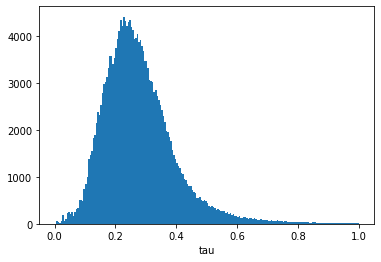

In [15]:
a = plt.hist(tau,bins=200,range=(0,1))
plt.xlabel('tau')

In [16]:
tau_trim = np.clip(tau,0,1) # tau should be between 0 and 1

## Making the depth map <a id="depth" />
Now that we have the needed quantities, we can begin to make our depth map.  Our procedure will be to create a Healpix map, use the coordinates of the HDU corners to identify which healpixels are spanned by each HDU, and add the value of $\tau$ for those HDUs to the appropriate Healpixels.  A couple of notes:

* Because the corners of the HDUs aren't guaranteed to go clockwise, or counter-clockwise, around the HDU, we might not be defining convex polygons when we do the healpixel mapping.  We'll need to order the corners so that they go in one direction, and don't jump an HDU along its diagonal
* We'll need to loop over all of the HDUs one at a time, which can be slow.  Parallel processing might help here.


In [17]:
#functions to order the vertices of HDU corners in counter-clockwise direction, so that their polygon is convex
# reference: https://algorithmtutor.com/Computational-Geometry/Area-of-a-polygon-given-a-set-of-points/
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'
    
def distance(p1, p2):
    d = np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    return d
    
def average_point_inside(points):
    x = 0
    y = 0
    for point in points:
        x += point.x
        y += point.y
    return Point(x / len(points), y / len(points))

def angle(p1, p2):
    k = (p2.y - p1.y) / distance(p1, p2)

    x2 = p2.x
    x1 = p1.x

    if k >= 0:
        if x2 >= x1: # First Quadrant
            return (2.0 * math.pi - math.asin(k))
        else: # Second Quadrant
            return (math.pi + math.asin(k))
    else:
        if x2 >= x1: # Fourth Quadrant
            return math.asin(-k)
        else: # Third Quadrant
            return (math.pi - math.asin(-k))
        
def sort_angular(points, reference_point):
    return sorted(points, key = lambda point: -angle(point, reference_point))

def sort_radec(ra,dec):
    points = [Point(ra[0],dec[0]), Point(ra[1],dec[1]), Point(ra[2],dec[2]), Point(ra[3],dec[3])]
    reference_point = average_point_inside(points)
    spoints =  sort_angular(points, reference_point)
    ra1s=[]
    dec1s=[]
    for p in spoints:
        ra1s.append(p.x)
        dec1s.append(p.y)
    return np.array(ra1s),np.array(dec1s)

#### Pull out the HDU corners

In [18]:
%%time
ratab = [np.array([row[0],row[1],row[2],row[3]]) for row in dfmc[['COR1RA1','COR2RA1','COR3RA1','COR4RA1']].values]
dectab = [np.array([row[0],row[1],row[2],row[3]]) for row in dfmc[['COR1DEC1','COR2DEC1','COR3DEC1','COR4DEC1']].values]

CPU times: user 594 ms, sys: 0 ns, total: 594 ms
Wall time: 594 ms


#### Sort the HDU corners in counter-clockwise direction

In [19]:
%%time
radectab_s = [sort_radec(ra1,dec1) for ra1,dec1 in zip(ratab,dectab)]
vectab = [hp.ang2vec(ra1,dec1,lonlat=True) for ra1, dec1 in radectab_s]

CPU times: user 5.63 s, sys: 0 ns, total: 5.63 s
Wall time: 5.62 s


#### Define the Healpix map

In [20]:
nside = 4096
print('Resolution is {:5.2f} arcmin'.format(hp.nside2resol(nside,arcmin=True)))
map = np.zeros(hp.nside2npix(nside)) # raw exposure map
tmap = map.copy() # teff map

Resolution is  0.86 arcmin


#### Loop over HDUs (slow!)

In [21]:
%%time
for vec,exptime,tau1 in zip(vectab,dfmc['fitsfile__exposure'],tau_trim):
    try:
        ipix = hp.query_polygon(nside,vec)
        map[ipix] += exptime
        tmap[ipix] += tau1 * exptime
    except:
        pass

CPU times: user 4min 26s, sys: 0 ns, total: 4min 26s
Wall time: 4min 26s


In [22]:
np.count_nonzero(tmap) #@@@

20496411

#### Show the map

/home/pothiers/sandbox/nat-nb/venv/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


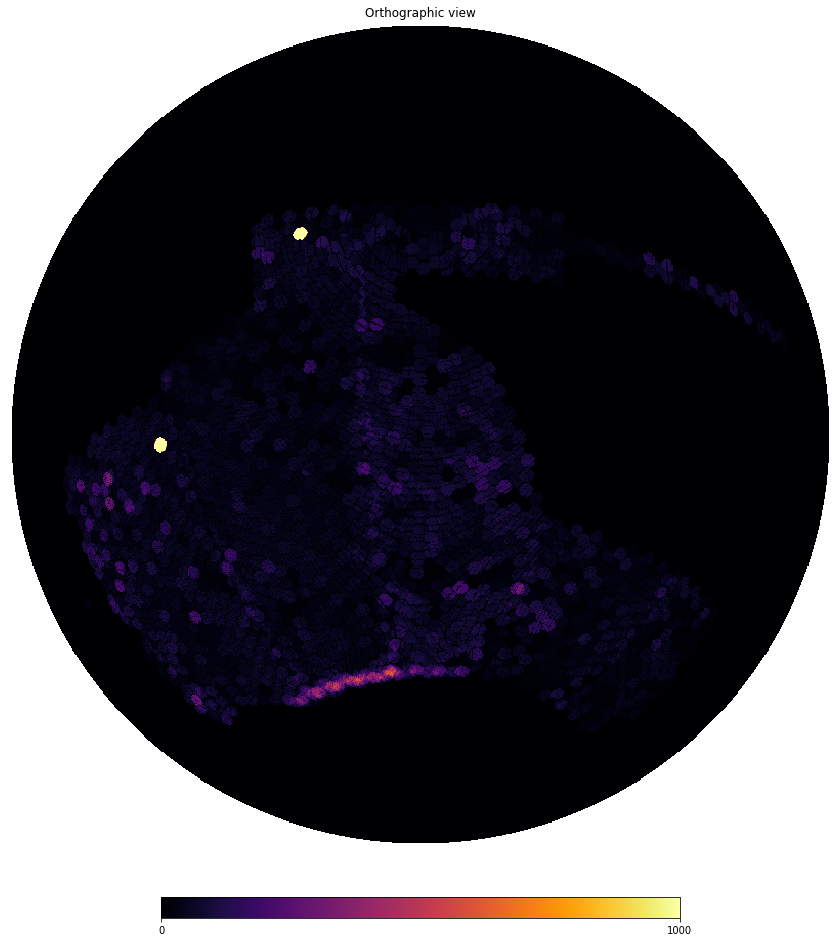

In [23]:
fig = plt.figure(figsize=(15,15))
cmap = copy.copy(matplotlib.cm.get_cmap("inferno"))
hp.orthview(tmap,rot=(20,-30),fig=1,cmap=cmap,half_sky=True,min=0,max=1000)

#### Zooming in

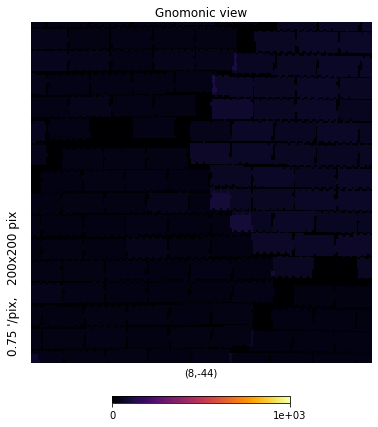

In [24]:
hp.gnomview(tmap,reso=0.75,cmap=cmap,rot=(8,-44),min=0,max=1000)

In [25]:
import datetime
elapsed = toc()  # Seconds since start of Notebook load (assuming fresh run)
print(f'Elapsed seconds={elapsed} on {natroot}')
print(f'Completed on: {str(datetime.datetime.now())}')
assert natroot == 'https://astroarchive.noirlab.edu', 'Notebook does NOT point to PRODUCTION'
elapsed

Elapsed seconds=377.9192870289553 on https://astroarchive.noirlab.edu
Completed on: 2021-02-01 14:02:32.883478


377.9192870289553

## Resources and references <a id="docs" />
* Advanced Search [notebook](https://github.com/NOAO/nat-nb)
* Nielsen, E. et al., 2016, [FERMILAB-TM-2610-AE-CD](https://www.osti.gov/biblio/1250877-limiting-magnitude-teff-image-quality-des-year)
* https://algorithmtutor.com/Computational-Geometry/Area-of-a-polygon-given-a-set-of-points/